***
<a id='beginning'></a> <!--\label{beginning}-->
* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [8. Calibration](8_0_introduction.ipynb)
***

Import standard modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

Import section specific modules:

In [2]:
from IPython.display import Image
from scipy import optimize

In [3]:
HTML('../style/code_toggle.html')

## Calibration Problem Set

In this problem set you will be required to discuss and implement [SteFCal](http://arxiv.org/abs/1410.2101). But first we give the code from Chapter 8 which implements the standard Levenberg-Marquardt approach. Please review Chapter 8 for a better description of what the existing code does. 

### A. Generating $uv$-tracks

lam =  0.214285714286
b [wavelengths] =  [ 466.66666667  933.33333333 1400.        ]


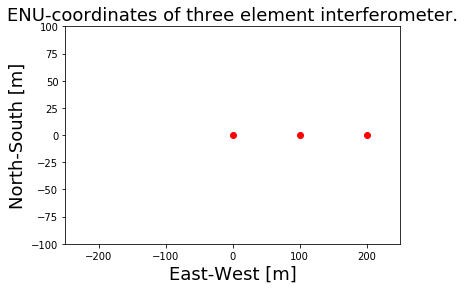

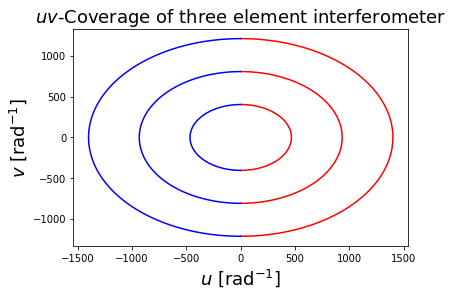

In [4]:
lam = 3e8/1.4e9 #observational wavelenth
print "lam = ",lam
b = np.array([100,200,300])/lam
print "b [wavelengths] = ",b
plt.plot(np.array([0,100,200]),np.array([0,0,0]),'ro')
plt.xlim([-250,250])
plt.ylim([-100,100])
plt.xlabel("East-West [m]", fontsize=18)
plt.ylabel("North-South [m]", fontsize=18)
plt.title("ENU-coordinates of three element interferometer.", fontsize=18)
plt.show()
H = np.linspace(-6,6,600)*(np.pi/12) #Hour angle in radians
delta = 60*(np.pi/180) #Declination in radians
u = np.zeros((len(b),len(H)))
v = np.zeros((len(b),len(H)))
for k in xrange(len(b)):
    u[k,:] = b[k]*np.cos(H)
    v[k,:] = b[k]*np.sin(H)*np.sin(delta)
    plt.plot(u[k,:],v[k,:],"r")
    plt.plot(-u[k,:],-v[k,:],"b")
plt.xlabel("$u$ [rad$^{-1}$]", fontsize=18)
plt.ylabel("$v$ [rad$^{-1}$]", fontsize=18)
plt.title("$uv$-Coverage of three element interferometer", fontsize=18)
plt.show()
u_m = np.zeros((len(b),len(b),len(H)))
v_m = np.zeros((len(b),len(b),len(H)))

u_m[0,1,:] = u[0,:] #the first two entries denote p and q and the third index denotes time
u_m[1,2,:] = u[1,:]
u_m[0,2,:] = u[2,:]

v_m[0,1,:] = v[0,:]
v_m[1,2,:] = v[1,:]
v_m[0,2,:] = v[2,:]

### B. Generating Visibilities

In [5]:
'''Creates the observed visibilities
point_sources - skymodel of point sources - (amplitude, l, m)
u_m - the u coordinates of observation (packed in a 2D structure)
v_m - the v coordinates of observation (packed in a 2D structure)
g - the antenna gain error vector
sig - the noise
'''
def create_vis_mat(point_sources,u_m,v_m,g,sig):
    D = np.zeros(u_m.shape)
    G = np.diag(g)
    #Step 1: Create Model Visibility Matrix
    for k in xrange(len(point_sources)): #for each point source
        l_0 = point_sources[k,1]
        m_0 = point_sources[k,2]
        D = D + point_sources[k,0]*np.exp(-2*np.pi*1j*(u_m*l_0+v_m*m_0))
    
    for t in xrange(D.shape[2]): #for each time-step
        
        #Step 2: Corrupting the Visibilities 
        D[:,:,t] = np.dot(G,D[:,:,t])
        D[:,:,t] = np.dot(D[:,:,t],G.conj()) 
        
        #Step 3: Adding Noise
        D[:,:,t] = D[:,:,t] + sig*np.random.randn(u_m.shape[0],u_m.shape[1]) + sig*np.random.randn(u_m.shape[0],u_m.shape[1])*1j
    
    return D

In [6]:
point_sources = np.array([(1,0,0),(0.5,(1*np.pi)/180,(0*np.pi)/180)]) #l and m are measures in radians
g = np.array([1.2+1.3j,1.1-1.5j,-1.3+0.7j])
sig = 0.1
D = create_vis_mat(point_sources,u_m,v_m,g,sig) #we corrupt our data and we add noise
M = create_vis_mat(point_sources,u_m,v_m,np.array([1,1,1]),0) #no corruption and no noise 

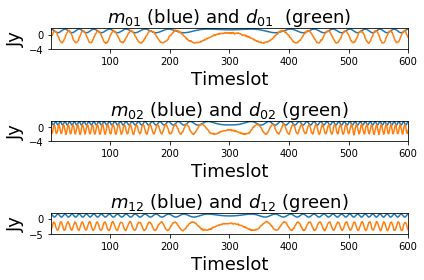

In [7]:
fig = plt.figure()

timeslots = np.cumsum(np.ones((len(M[0,1,:]),)))

#We only plot the real part of visibilities

#Plotting Baseline 01
ax = plt.subplot("311")
ax.set_title("$m_{01}$ (blue) and $d_{01}$  (green)", fontsize=18)
ax.plot(timeslots,M[0,1,:].real)
ax.plot(timeslots,D[0,1,:].real)
ax.set_xlabel("Timeslot", fontsize=18)
ax.set_ylabel("Jy", fontsize=18)
ax.set_xlim([1,len(M[0,1,:])])
y_t = ax.get_yticks()
y_t = y_t[::2]
ax.set_yticks(y_t)

#Plotting Baseline 02
ax = plt.subplot("312")
ax.set_title("$m_{02}$ (blue) and $d_{02}$ (green)", fontsize=18)
ax.plot(timeslots,M[0,2,:].real)
ax.plot(timeslots,D[0,2,:].real)
ax.set_xlabel("Timeslot", fontsize=18)
ax.set_ylabel("Jy", fontsize=18)
ax.set_xlim([1,len(M[0,1,:])])
y_t = ax.get_yticks()
y_t = y_t[::2]
ax.set_yticks(y_t)

#Plotting Baseline 12
ax = plt.subplot("313")
ax.set_title("$m_{12}$ (blue) and $d_{12}$ (green)", fontsize=18)
ax.plot(timeslots,M[1,2,:].real)
ax.plot(timeslots,D[1,2,:].real)
ax.set_xlabel("Timeslot", fontsize=18)
ax.set_ylabel("Jy", fontsize=18)
ax.set_xlim([1,len(M[0,1,:])])
y_t = ax.get_yticks()
y_t = y_t[::2]
ax.set_yticks(y_t)

plt.tight_layout()

plt.show()

### C. Calibrate Using LM

In [8]:
'''Unpolarized direction independent calibration entails finding the G that minimizes ||R-GMG^H||. 
This function evaluates D-GMG^H.
g is a vector containing the real and imaginary components of the antenna gains.
d is a vector containing a vecotrized R (observed visibilities), real and imaginary.
m is a vector containing a vecotrized M (predicted), real and imaginary.
r is a vector containing the residuals.
''' 
def err_func(g,d,m):
    Nm = len(d)/2
    N = len(g)/2
    G = np.diag(g[0:N]+1j*g[N:])
    D = np.reshape(d[0:Nm],(N,N))+np.reshape(d[Nm:],(N,N))*1j #matrization
    M = np.reshape(m[0:Nm],(N,N))+np.reshape(m[Nm:],(N,N))*1j
    T = np.dot(G,M)
    T = np.dot(T,G.conj())
    R = D - T
    r_r = np.ravel(R.real) #vectorization
    r_i = np.ravel(R.imag)
    r = np.hstack([r_r,r_i])
    return r

In [14]:
'''This function finds argmin G ||D-GMG^H|| using Levenberg-Marquardt. It uses the optimize.leastsq scipy to perform
the actual minimization.
D is your observed visibilities matrx.
M is your predicted visibilities.
g the antenna gains.
G = gg^H.''' 
def create_G_LM(R,M):
       N = R.shape[0]
       temp =np.ones((R.shape[0],R.shape[1]) ,dtype=complex)
       G = np.zeros(R.shape,dtype=complex)
       g = np.zeros((R.shape[0],R.shape[2]),dtype=complex)
      
       for t in xrange(R.shape[2]):
           g_0 = np.ones((2*N,))
           g_0[N:] = 0
           r_r = np.ravel(R[:,:,t].real)
           r_i = np.ravel(R[:,:,t].imag)
           r = np.hstack([r_r,r_i])
           m_r = np.ravel(M[:,:,t].real)
           m_i = np.ravel(M[:,:,t].imag)
           m = np.hstack([m_r,m_i])
           g_lstsqr_temp = optimize.leastsq(err_func, g_0, args=(r, m))
           g_lstsqr = g_lstsqr_temp[0]          
           
           G_m = np.dot(np.diag(g_lstsqr[0:N]+1j*g_lstsqr[N:]),temp)
           G_m = np.dot(G_m,np.diag((g_lstsqr[0:N]+1j*g_lstsqr[N:]).conj()))           

           g[:,t] = g_lstsqr[0:N]+1j*g_lstsqr[N:]       
           G[:,:,t] = G_m
         
       return g,G

In [15]:
glm,Glm = create_G_LM(D,M)

3


In [11]:
R_c = Glm**(-1)*D

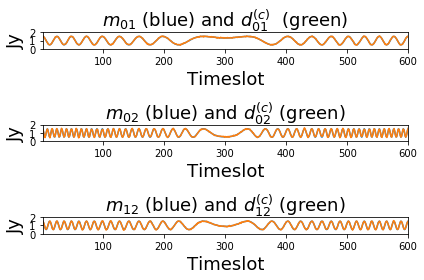

In [12]:
fig = plt.figure()

timeslots = np.cumsum(np.ones((len(M[0,1,:]),)))g_0 = np.ones((2*N,))
           g_0[N:] = 0
           r_r = np.ravel(R[:,:,t].real)
           r_i = np.ravel(R[:,:,t].imag)
           r = np.hstack([r_r,r_i])
           m_r = np.ravel(M[:,:,t].real)
           m_i = np.ravel(M[:,:,t].imag)
           m = np.hstack([m_r,m_i])
           g_lstsqr_temp = optimize.leastsq(err_func, g_0, args=(r, m))
           g_lstsqr = g_lstsqr_temp[0]          
           
           G_m = np.dot(np.diag(g_lstsqr[0:N]+1j*g_lstsqr[N:]),temp)
           G_m = np.dot(G_m,np.diag((g_lstsqr[0:N]+1j*g_lstsqr[N:]).conj()))           

           g[:,t] = g_lstsqr[0:N]+1j*g_lstsqr[N:]       
           G[:,:,t] = G_m

#We only plot the real part of visibilities

#Plotting Baseline 01
ax = plt.subplot("311")
ax.set_title("$m_{01}$ (blue) and $d_{01}^{(c)}$  (green)", fontsize=18)
ax.plot(timeslots,M[0,1,:].real)
ax.plot(timeslots,R_c[0,1,:].real)
ax.set_xlabel("Timeslot", fontsize=18)
ax.set_ylabel("Jy", fontsize=18)
ax.set_xlim([1,len(M[0,1,:])])
y_t = ax.get_yticks()
y_t = y_t[::2]
ax.set_yticks(y_t)

#Plotting Baseline 02
ax = plt.subplot("312")
ax.set_title("$m_{02}$ (blue) and $d_{02}^{(c)}$ (green)", fontsize=18)
ax.plot(timeslots,M[0,2,:].real)
ax.plot(timeslots,R_c[0,2,:].real)
ax.set_xlabel("Timeslot", fontsize=18)
ax.set_ylabel("Jy", fontsize=18)
ax.set_xlim([1,len(M[0,1,:])])
y_t = ax.get_yticks()
y_t = y_t[::2]
ax.set_yticks(y_t)

#Plotting Baseline 12
ax = plt.subplot("313")
ax.set_title("$m_{12}$ (blue) and $d_{12}^{(c)}$ (green)", fontsize=18)
ax.plot(timeslots,M[1,2,:].real)
ax.plot(timeslots,R_c[1,2,:].real)
ax.set_xlabel("Timeslot", fontsize=18)
ax.set_ylabel("Jy", fontsize=18)
ax.set_xlim([1,len(M[0,1,:])])
y_t = ax.get_yticks()
y_t = y_t[::2]
ax.set_yticks(y_t)

plt.tight_layout()

plt.show()

### 1. SteFCal: Theoretical derivation

Please derive, discuss and present the SteFCal calibration algorithm? [20] 

**Subtotal 20**

### 2. SteFCal: Practical implementation 

a) Please Complete the following function. This function is suppose to be the SteFCal equivalent of `create_G_LM`. In other words it should compute `g` and `G` but instead of using LM it should use SteFCal. [20]  

In [13]:
   '''This function finds argmin G ||R-GMG^H|| using StEFCal.
   D is your observed visibilities matrx.
   M is your predicted visibilities.
   imax maximum amount of iterations.
   tau stopping criteria.
   g the antenna gains.
   G = gg^H.'''
   def create_G_stef(self,D,M,imax,tau):
       G = np.zeros(D.shape,dtype=complex)
       g = np.zeros((D.shape[0],D.shape[2]),dtype=complex)

       #Complete the rest of the function
         
       return g,G

b) Use `create_G_stef` to calibrate the visibilities we created in Section B. 
Plot the real part of the corrected visibilities and the true visibilities.How does your result compare to what we obtained with LM? [10]

**Subtotal 30**

**Full Marks 50**